In [27]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

import os

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

import gphelper as gp
import ImageTools as it
import DataTools as dt

/home/ryanhausen/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:339: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


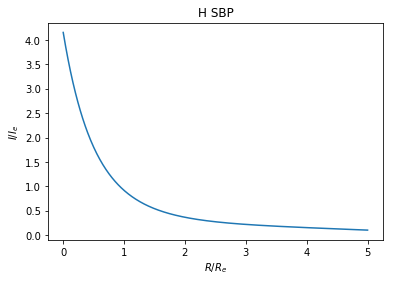

In [58]:
X = np.linspace(0.001, 5, 500)[:, np.newaxis]
h_model = gp.GPHelper(restore_file='./gp-models/gp_h.json')
y_gp = 10**h_model.sample(X)

plt.title('H SBP')
plt.ylabel('$I/I_e$')
plt.xlabel('$R/R_e$')
plt.plot(X, y_gp)
plt.show()

In [151]:
def sbp_to_int(x, y):
    delta_x = np.diff(x)[0]/2
    xs = [np.pi*((_x+delta_x)**2-(_x-delta_x)**2) for _x in x.flatten()]
    xs = np.array(xs)
    
    weighted_y = xs * y
    I_tot = weighted_y.sum()
    int_I = np.cumsum(weighted_y/I_tot)
    return int_I, I_tot, xs

def img_sbp_to_int(x, y):
    I_tot = y.sum()
    I_int = np.cumsum(y)/I_tot
    
    return I_int

def int_to_sbp(x, y, y_tot):
    return (np.array([0] + np.diff(y).tolist())*y_tot)/x

def eta_line(x, difference_at_1):
    def delta_l(x, diff):
        return diff - diff * (1-x)**2
    
    def delta_r(x, diff):
        return diff - diff * ((x-1)/(x.max()-1))**2
    
    eta = np.zeros_like(x)
    eta[x<=1] = delta_l(x[x<=1], difference_at_1)
    eta[x>1] = delta_r(x[x>1], difference_at_1)

    return eta

# https://ned.ipac.caltech.edu/level5/March05/Graham/Graham2.html
def sersic(x):
    def b(n):
        return 1.9992*n-0.3271

    def I(r):
        """Assuming that I_e=1.0 and that R_e=1.0"""
        n = 4
        return np.exp(-b(n) * (np.power(r, 1/n)  - 1))

    return I(x)

def get_random_spheroids(num=10):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
        
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)
    
    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        src_map = segmap==int(s.split('_')[1])
        sources.append((img, src_map))
    
    return sources

def make_nonnegative(img):
    epsilon = 0 if len(img[img<0])==0 else img[img>0].min()
    return img + abs(img.min()) + epsilon

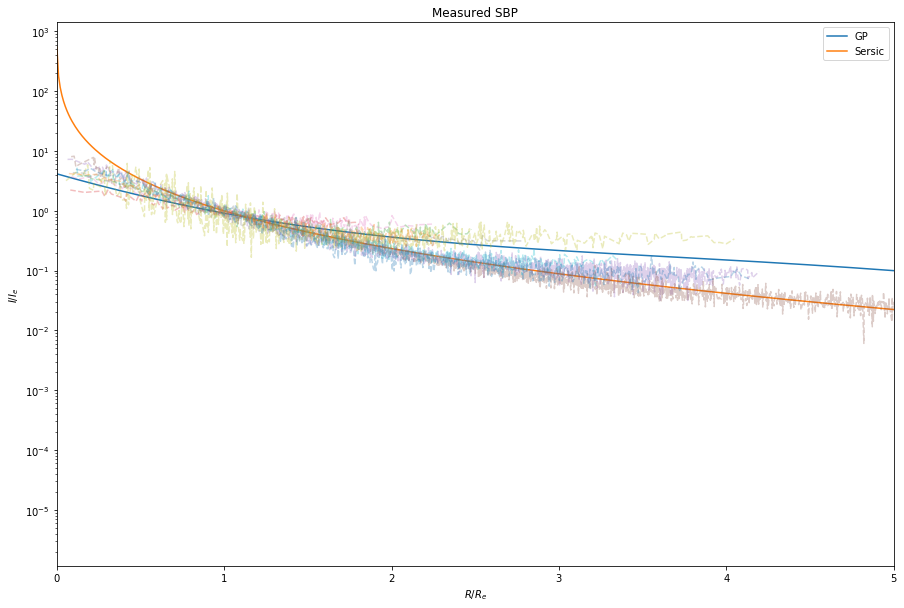

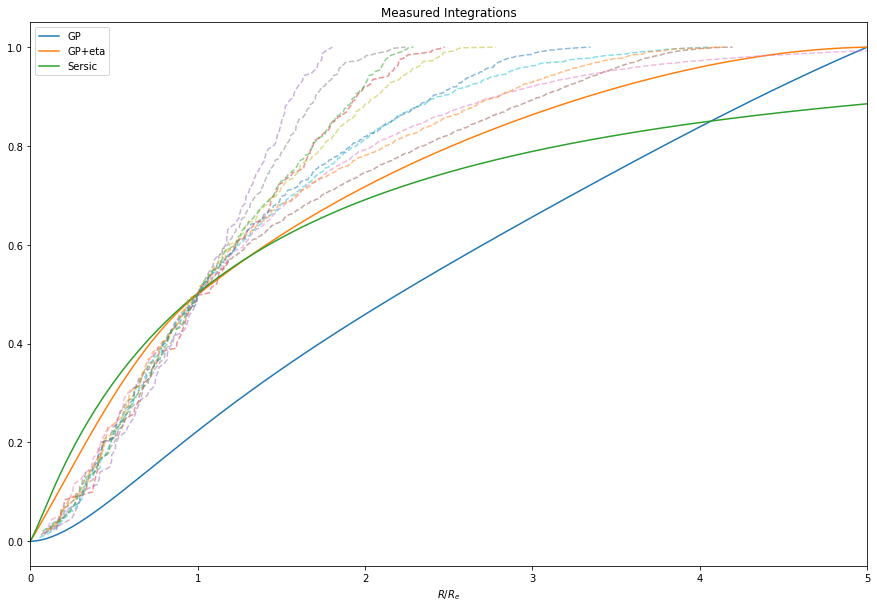

In [152]:
y_gp_int, I_tot, wx = sbp_to_int(X.flatten(), y_gp.flatten())
diff_at_1 = 0.5-y_gp_int[np.square(X-1).argmin()]
y_gp_eta = y_gp_int + eta_line(X.flatten(), diff_at_1)

sources = []
for img, src_map in get_random_spheroids():
    rs, fs, ie, re = it.rs_fs_ie_re(make_nonnegative(img), src_map)
    #rs /= re
    #fs /= ie

    sources.append((rs, fs, re, ie))

X_sersic = np.linspace(0.001, 50, 5000)[:, np.newaxis]
y_sersic = sersic(X_sersic)
y_sersic_int, _, _ = sbp_to_int(X_sersic.flatten(), y_sersic.flatten())

plt.figure(figsize=(15, 10))
plt.title('Measured SBP')
plt.xlabel('$R/R_e$')
plt.ylabel('$I/I_e$')
plt.xlim((0,5))

plt.semilogy(X, y_gp, label='GP')
plt.semilogy(X_sersic, y_sersic, label='Sersic')

for x, y, r, i in sources:
    plt.semilogy(x/r, y/i, '--', alpha=0.3)
plt.legend()
    
    
plt.figure(figsize=(15, 10))
plt.title('Measured Integrations')
plt.xlabel('$R/R_e$')
plt.xlim((0,5))

plt.plot(X, y_gp_int, label='GP')
plt.plot(X, y_gp_eta, label='GP+eta')
plt.plot(X_sersic, y_sersic_int, label='Sersic')

for x, y, r, i in sources:
    s_int = img_sbp_to_int(x.flatten(), y)
    plt.plot(x/r, s_int, '--', alpha=0.5)
m = max([max(s[0]) for s in sources])
plt.legend()
    
plt.show()

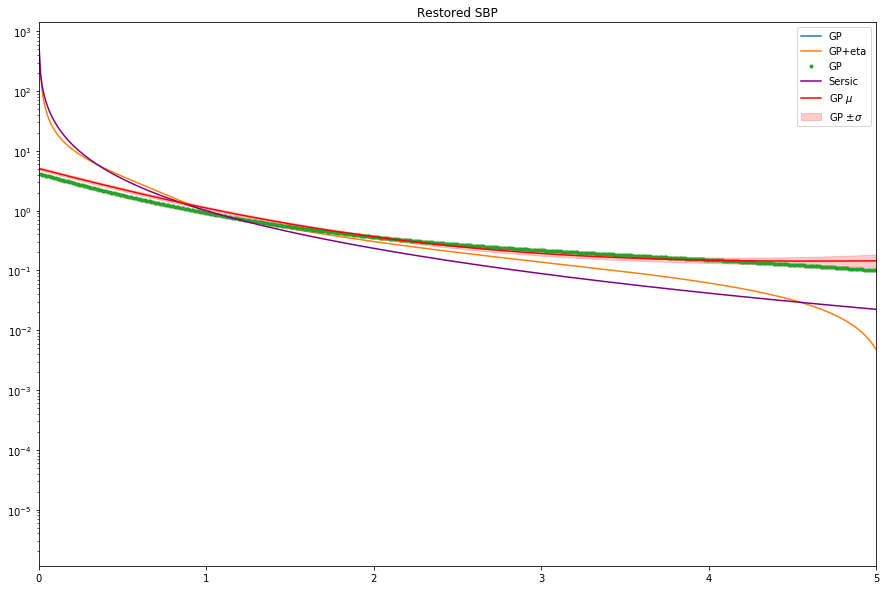

In [153]:
y_mean, y_std = h_model.predict(X, return_std=True)
y_pls_std = 10**(y_mean + y_std)
y_min_std = 10**(y_mean - y_std)
y_mean =  10 **y_mean

restored_gp_eta = int_to_sbp(wx, y_gp_eta, I_tot)
restored_gp = int_to_sbp(wx, y_gp_int.flatten(), I_tot)

plt.figure(figsize=(15, 10))
plt.title('Restored SBP')
plt.semilogy(X, y_gp, label='GP')
plt.semilogy(X, restored_gp_eta, label='GP+eta')
plt.semilogy(X, restored_gp, '.', label='GP')
plt.semilogy(X_sersic, y_sersic, label='Sersic', color='purple')
plt.semilogy(X, y_mean, label='GP $\mu$', color='r')
plt.fill_between(X.flatten(), y_min_std, y_pls_std, label='GP $\pm\sigma$', alpha=0.2, color='r')
plt.xlim(0,5)
plt.legend()
plt.show()